<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/02_Dataset_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import os, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()

Tensorflow version 1.13.1


In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Colab-only auth
You would need this if you were accessing private GCS buckets. The training data for this exercise is in a public bucket for which authentication is not necessary.

In [0]:
# IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
# if IS_COLAB_BACKEND:
#   from google.colab import auth
#   auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too

## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # flower labels (folder names in the data)

## Read images and labels [WORK WAS REQUIRED HERE]
1. Use `fileset=`[`tf.data.Dataset.list_files`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) to scan the data folder
1. Iterate through the dataset of filenames: `for filename in fileset:...` . 
 * Does it work ?
 * No! But Python iteration though a Dataset works in eager mode. Enable eager mode in the first cell, restart the runtime and try again.
 * tip: to limit the size of the dataset for display, you can use [`Dataset.take()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take). Like this: `for data in dataset.take(10): ....`
 * It works but why are Tensors returned ? Get proper values by applying .numpy() to the tensors.
1. Use [`tf.data.Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to decode the JPEG files. You will find useful TF code snippets below.
 * Iterate on the image dataset. You can use .numpy().shape to only see the data sizes.
  * Are all images of the same size ?
1. Now create a training dataset: you have images but you also need labels:
 *  the labels (flower names) are the directory names. You will find useful TF code snippets below for parsing them.
 * If you do "`return image, label`" in the decoding function, you will have a Dataset of pairs (image, label).
1. Look at the flowers with the `display_9_images_from_dataset` function. It expects the Dataset to have `(image, label)` elements.
1. Code for iterating on a dataset in non-eager mode is also provided in the snippets below. Have a look, it is a bit more complex...

Pattern matches 3670 images.
gs://flowers-public/dandelion/5762590366_5cf7a32b87_n.jpg
gs://flowers-public/sunflowers/20183071136_c297e74fcc_m.jpg
gs://flowers-public/sunflowers/4933230161_12f3ee7587.jpg
gs://flowers-public/tulips/14067761295_7cfe6a42e9.jpg
gs://flowers-public/dandelion/7808545612_546cfca610_m.jpg
gs://flowers-public/daisy/162362896_99c7d851c8_n.jpg
gs://flowers-public/dandelion/7015947703_11b30c20c9_n.jpg
gs://flowers-public/tulips/14491997336_36ba524713.jpg
gs://flowers-public/dandelion/2039797043_d5b709f275_n.jpg
gs://flowers-public/tulips/15275190769_0ed7bbf490.jpg
(240, 180, 3)
(281, 500, 3)
(375, 500, 3)
(266, 500, 3)
(333, 500, 3)
(333, 500, 3)
(240, 207, 3)
(334, 500, 3)
(240, 320, 3)
(333, 500, 3)
(213, 320, 3) tulips
(211, 320, 3) tulips
(200, 320, 3) sunflowers
(240, 320, 3) sunflowers
(240, 320, 3) sunflowers
(333, 500, 3) dandelion
(240, 320, 3) tulips
(240, 320, 3) dandelion
(240, 320, 3) daisy
(240, 320, 3) roses


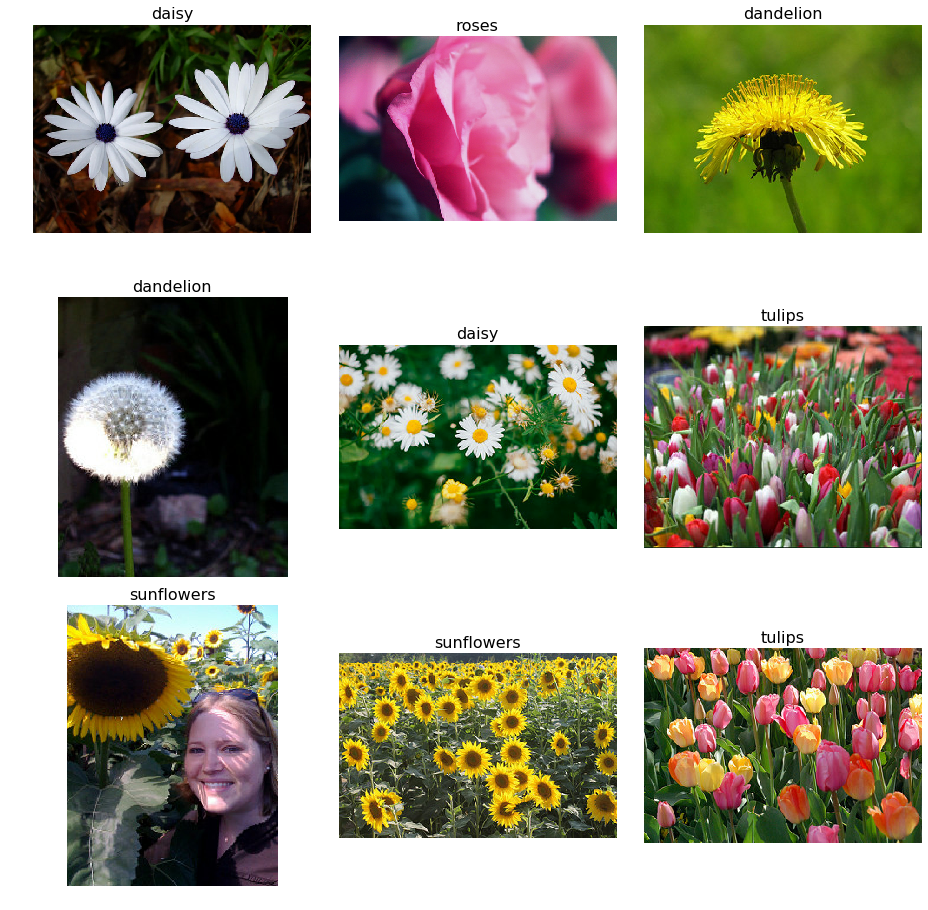

In [9]:
nb_images = len(tf.gfile.Glob(GCS_PATTERN))
print("Pattern matches {} images.".format(nb_images))

### QUESTIONS 1. and 2.
filenames_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_dataset.take(10):
  print(filename.numpy().decode('utf-8'))
  
### QUESTION 3.

# copy-pasted from "useful code snippets" below
def decode_jpeg(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

image_dataset = filenames_dataset.map(decode_jpeg)
for image in image_dataset.take(10):
  print(image.numpy().shape)
  
### QUESTION 4.

# copy-pasted from "useful code snippets" below
def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

dataset = filenames_dataset.map(decode_jpeg_and_label)
for image, label in dataset.take(10):
  print(image.numpy().shape, label.numpy().decode('utf-8'))

  ### QUESTION 5.
display_9_images_from_dataset(dataset)

## Useful code snippets

### Decode a JPEG in Tensorflow

In [0]:
def decode_jpeg(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

### Decode a JPEG and extract folder name in Tensorflow

In [0]:
def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return image, label

### Read from dataset in non-eager mode

In [0]:
assert not tf.executing_eagerly(), "This cell will only work in non-eager mode"

next_data_item = dataset.make_one_shot_iterator().get_next()
with tf.Session() as ses:
  while True:
    try:
      image, label = ses.run(next_data_item)
      # ses.run returns numpy data
      print(image.shape, label)
    except tf.errors.OutOfRangeError:
      print("the end")
      break;

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
